# Fine Tuning Llama2 With Custom Data Using LoRA and PEFT

PEFT - when applies transfer learning on these LLM models, it freezes most of the weights of that LLM and only some of the weights will be retrained. Based on that it provides accurate results on our custom data.

## Installing All Required Libraries

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 

- **`accelerate`** - provides high-performance, energy-efficient computation on the CPU by leveraging its vector-processing capability
- **`peft`** - parameter efficient fine tuning, which is used to perform LoRA.
- **`bitsandbytes`** - To perform quantization of weights from 32 bit (float32) to probably like 8 bit (int8) since running in Google Colab
- **`transformers`** - To use pretrained models
- **`trl`** - trl (transformer reinforcement learning) provides a set of tools to train transformer language models with Reinforcement Learning

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

### **In case of Llama 2, the following prompt template is used for the chat models**
System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

**Hence, we need to have our data in the following format**


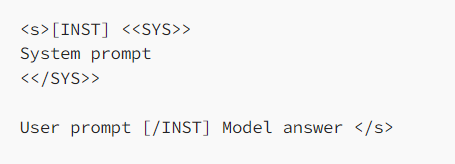

## Fine Tuning Llama2

- Free Google Colab offers a 15GB Graphics (Limited Resources that are barely enough to store Llama 2–7b’s weights)
- We also need to consider the overhead due to optimizer states, gradients, and forward activations
- So, Full fine-tuning is not possible here. We need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.
- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

1. Loading the llama-2-7b-chat-hf model (chat model)
2. Train it on the icare_chat_data, which will produce our fine-tuned model Llama-2-7b-chat-finetune

**QLoRA will use a rank of 64 inorder to find the low rank index, with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch**

### Setting Parameters

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "meta-llama/Llama-2-7b-chat-hf"

# # The instruction dataset to use
# dataset_name = "data/icare_chat_data"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetuned"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension (rank of 64)
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True if using A100 GPU)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (similarity)
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# Supervised Fine Tuning (SFT) Parameters
################################################################################

# Maximum sequence length to use
max_seq_length = 1024

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

**HugginFace Login**

In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

### Loading Custom Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class CustomTextDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        with open(file_path, 'r', encoding='utf-8') as file:
            self.lines = [line.strip() for line in file.readlines() if line.strip()]

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, index):
        text = self.lines[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            return_token_type_ids=False,
            truncation=True
        )
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']
        }

# Path to your text file
file_path = "/content/data/icare_chat_data.txt"

# Assuming you've already loaded or defined a tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Create a dataset instance
max_length = 1024
custom_dataset = CustomTextDataset(file_path, tokenizer, max_length)

# Now, you can use `custom_dataset` in your training loop in place of `dataset`


- First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.
- Then, we’re configuring bitsandbytes for 4-bit quantization.
- Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.
- Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

### Loading Data and Fine Tuning

In [ ]:
# # Load dataset (you can process it here)
# dataset = load_dataset(custom_dataset, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLama2 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=custom_dataset, #custom_dataset
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

## Checking The Training Plots on Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

## Using The Pipeline To Ask Questions

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "I'm feeling lonely and I can't meet new people at the same time."
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

## Storing The New Fine Tuned Llama2 Model

**How can we store our new Llama-2-7b-chat-finetuned model now? We need to merge the weights from LoRA with the base model. Unfortunately, as far as I know, there is no straightforward way to do it: we need to reload the base model in FP16 precision and use the peft library to merge everything.**

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

## Pushing The Model To HuggingFace

**Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.**

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!huggingface-cli login

model.push_to_hub("entbappy/Llama-2-7b-chat-finetune", check_pr=True)

tokenizer.push_to_hub("entbappy/Llama-2-7b-chat-finetune",check_pr=True)

#### Now This finetuned model can be used for inference by loading it like any other Llama 2 model from the Hub.